In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import numpy as np
from matplotlib import pyplot as plt
from incense import ExperimentLoader
from utils import *

from metatop.metamaterial import setup_metamaterial
from metatop.image import img2func

import pickle
import incense

from metatop.optimization.optimizationstate import OptimizationState
from metatop.filters import setup_filter, jax_projection
from metatop.mechanics import calculate_elastic_constants
from mechanics import polar_plot, rotate_elasticity_matrix

In [16]:
# connect to mongodb
loader = ExperimentLoader(
    mongo_uri='mongodb://localhost:27017',
    db_name='metatop'
)
# filter_tags = ['bad']
# experiments = load_experiments(loader, 'extremal', filter_tags)

In [17]:
e = loader.find_by_id(509)
e.to_dict()['info']['final_C']

array([[ 0.2026347 ,  0.00111676, -0.00022015],
       [ 0.00111676,  0.12015038, -0.07949402],
       [-0.00022015, -0.07949402,  0.11860156]])

In [24]:
# extract relevant experiments and convert to simulation objects
idxs = (510, 529, 539, 553, ) # took out 509
DIC_nus = {539:0.2, 510:0.03, 529:0.03, 553:0.06}

def filter_and_project(x, ops):
    x = ops.filt_fn(x)
    x = jax_projection(x, ops.beta, ops.eta)
    return x

def forward_sim(metamate, ops):
    m = np.diag(np.array([1, 1, np.sqrt(2)]))
    orig_x = metamate.x.copy(deepcopy=True)
    x_fem = filter_and_project(metamate.x.vector()[:], ops)
    metamate.x.vector()[:] = x_fem
    sols, Chom, _ = metamate.solve()
    Chom = m @ Chom @ m # convert to standard notation
    metamate.x = orig_x # reset metamates density to orig density
    return sols, Chom

def setup(idxs, test_E_min=None, test_nu=0.1):
    exp_dict = {}
    for idx in idxs:
        exp = loader.find_by_id(idx)
        config = exp.to_dict()['config']
            
        for k, v in exp.artifacts.items():
            if '.pkl' in k.lower():
                data = v.as_type(incense.artifact.PickleArtifact).render()
                x = data['x']

        new_nu = 0.1
        if test_E_min == None:
            print("test_E_min is None. Using original sim E_min")
        new_E_min = test_E_min or config['E_min']
        # print(new_E_min)

        metamate = setup_metamaterial(config['E_max'], new_E_min, new_nu, config['nelx'], config['nely'], mesh_cell_type='tri', domain_shape='square')
        metamate.x.vector()[:] = x[:-1]
        filt, filt_fn = setup_filter(metamate, config['norm_filter_radius'])
        ops = OptimizationState(beta=config['start_beta']*2**(config['n_betas']-1),
                                eta=0.5,
                                filt=filt,
                                filt_fn=filt_fn)
        
        exp_dict[exp.id] = {'exp': exp,
                            'metamate': metamate,
                            'filt': filt,
                            'filt_fn': filt_fn,
                            'ops': ops,
                            'old_Chom': exp.to_dict()['info']['final_C'],
                            'old_input_nu': config['nu'],
                            'new_input_nu': new_nu,
                            'old_input_E_min': config['E_min'],
                            'new_input_E_min': new_E_min
                            }
    return exp_dict

def run_sims(exp_dict):
    err = []
    for id, exp in exp_dict.items():
        # print(f"Simulating experiment {id}\nNew nu {exp['new_input_nu']}, old nu: {exp['old_input_nu']}\nNew E_min: {exp['new_input_E_min']}, old E_min: {exp['old_input_E_min']}\n")
        exp['sols'], C = forward_sim(exp['metamate'], 
                                        exp['ops'])
        if id == 529:
            C = rotate_elasticity_matrix(C, np.pi/4, input_style='mandel', output_style='mandel')
            exp['old_Chom'] = rotate_elasticity_matrix(exp['old_Chom'], np.pi/4, input_style='mandel', output_style='mandel')
        exp['new_Chom'] = C
        exp['old_props'] = calculate_elastic_constants(exp['old_Chom'], 
                                                    input_style='mandel')
        exp['new_props'] = calculate_elastic_constants(exp['new_Chom'], 
                                                    input_style='mandel')
        
        if exp['old_input_nu'] == exp['new_input_nu']:
            print("Old nu and new nu are the same. Checking if Chom is the same.")
            assert np.linalg.norm(exp['old_Chom'] - exp['new_Chom']) < 1e-6
        # err.append(np.abs(exp_dict[id]['old_props']['nu12'] - exp_dict[id]['new_props']['nu12']))
        err.append((DIC_nus[id] - exp_dict[id]['new_props']['nu21'])/DIC_nus[id])
    
    return err

def obj(test_E_min):
    print(f'Checking {test_E_min[0]:.5f}')
    exp_dict = setup(idxs, test_E_min=test_E_min[0])
    err = run_sims(exp_dict)
    print(f'Error: {np.linalg.norm(err):.5f}')
    return np.linalg.norm(err)


In [25]:
from scipy.optimize import minimize

initial_guess = [1/40]
res = minimize(obj, initial_guess, bounds=[(1e-2, 1.)])
opt_E = res.x
print(f"Optimum E_min: {opt_E[0]:.3f}")

Checking 0.02500
Loading filter from cache
Loading filter from cache
Loading filter from cache
Loading filter from cache
Error: 11.81147
Checking 0.02500
Loading filter from cache
Loading filter from cache
Loading filter from cache
Loading filter from cache
Error: 11.81147
Checking 1.00000
Loading filter from cache
Loading filter from cache
Loading filter from cache
Loading filter from cache
Error: 3.40343
Checking 1.00000
Loading filter from cache
Loading filter from cache
Loading filter from cache
Loading filter from cache
Error: 3.40343
Optimum E_min: 1.000


In [ ]:
# opt_E = res.x
# exp_dict = setup(idxs, test_E_min=opt_E, test_nu=0.1)
# run_sims(exp_dict)

In [8]:
# exp_dict=setup(idxs, test_E_min=1/10, test_nu=0.1)
# run_sims(exp_dict)

Loading filter from cache
Loading filter from cache
Loading filter from cache
Loading filter from cache


[0.024430927283551722,
 0.0074221275614281615,
 0.10832619862327986,
 0.13682658160735067]

OLD
{'E1': 0.2148052072329153, 'E2': 0.2166874649869552, 'G12': 0.06478897029216953, 'nu12': -0.27376255594417426, 'nu21': -0.27616143491144696, 'eta121': -0.014536166325124064, 'eta122': 0.024647174806657728}
NEW
{'E1': 0.40262823308962237, 'E2': 0.403602496580258, 'G12': 0.1299643534456709, 'nu12': 0.022577872438571837, 'nu21': 0.022632505459819124, 'eta121': -0.005846994385871874, 'eta122': 0.007354090908827363}


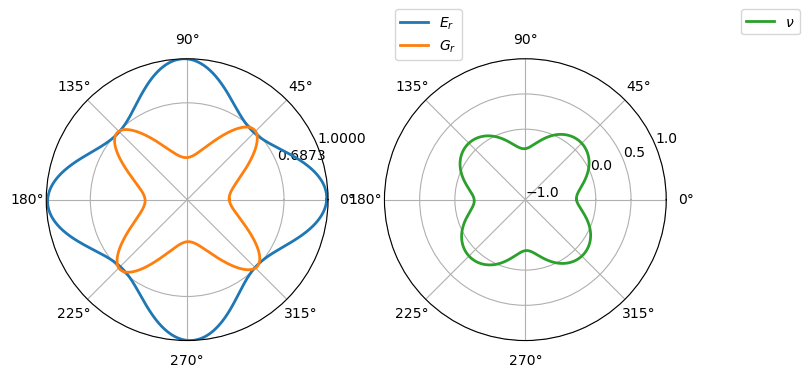

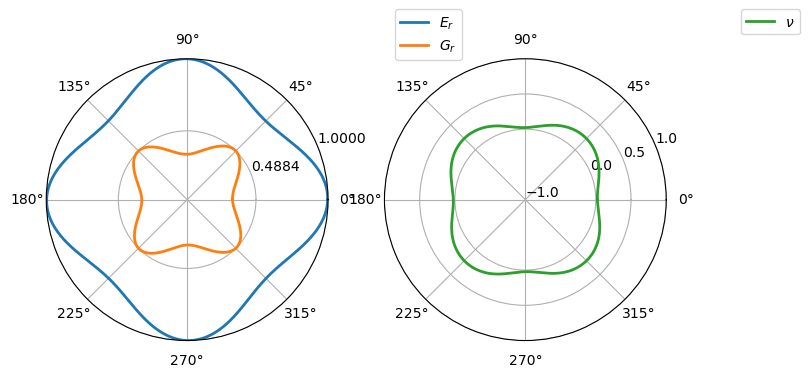

In [13]:
id = 529
input_style='mandel'
size=(8,8)
fig1, *_ = polar_plot(exp_dict[id]['old_Chom'], input_style=input_style, size=size);
fig2, *_ = polar_plot(exp_dict[id]['new_Chom'], input_style=input_style, size=size);

print('OLD')
print(exp_dict[id]['old_props'])
print('NEW')
print(exp_dict[id]['new_props'])

In [10]:
# least squares fit of E_max/E_min to fit PR of the different samples
# Seed the TO with the models we already have
# What's the sim values? Do they match reality now? How off are we?
# Run general TO search to find total range of property values

# Write abstract for Mechanical Metamaterial Foams toward Robotics